# Session 2: Understanding the data

1. Manipulate the data
  1. Calculate daily fuel consumption
  1. Calculate daily fuel prices
  1. Estimate fuel consumption for missing states and estimate seasonality from prices
1. Filter and group the important locations by revenue to reduce complexity 
1. Merge all data into a dataframe

### 4.0 Manipulate the data

### 4.1 Calculate daily fuel consumption

Originally, fuel consumption is given daily per state.

The intention is to calculate this consumption by location using the `fuel consumption per capita`

* Fuel consumption: State-Day -> Location-Day
    * Given data:
        * Fuel consumption: State - Day
        * Population: Location
    1. Estimate fuel consumption per capita in the state
  $fpc = \textrm{fuel in state} / \textrm{people in state}$
    1. Map the state's cunsumption per capita into the locations
  $fpl = fpc \cdot \textrm{people in location}$

### 4.1.1 Load population data

In [ ]:
pop = pd.read_csv('short_censo2020.csv', header=0).rename(columns={"ENTIDAD": "state_key", "NOM_ENT": "state", "MUN": "loc_key", "NOM_MUN": "loc", "POBTOT": "pop", "TVIVHAB": "hab_houses", "VPH_AUTOM": "cars_per_house"})
pop.sample(5)

,state_key,state,loc_key,loc,pop,hab_houses,cars_per_house
261,11,Guanajuato,10,Coroneo,5428.896779,1536.770089,858.440336
1380,30,Veracruz de Ignacio de la Llave,28,Boca del Río,230275.212272,74365.052232,34861.943688
569,15,México,42,Ixtlahuaca,139670.996475,32870.862263,12165.368666
1356,29,Tlaxcala,55,San Lucas Tecopilco,3468.139344,887.885654,335.712905
1349,29,Tlaxcala,48,La Magdalena Tlaltelulco,22828.319692,5536.087038,103.676044


### 4.1.2 Format coordinates information 

In [ ]:
coords = coords.rename(columns={"CVE_ENT": "state_key", "STATE": "state", "CVEGEO": "key", "CVE_MUN": "loc_key", "MUN": "loc"})
coords.sample(5)

,state_key,state,key,loc_key,loc,lat,lon
1152,20,Oaxaca,20134,134,San Felipe Jalapa de Díaz,-96.535101,18.069645
521,13,Hidalgo,13065,065,Tetepango,-99.151826,20.114407
1738,21,Puebla,21144,144,San Salvador Huixcolotla,-97.772333,18.926517
439,12,Guerrero,12042,042,Mártir de Cuilapan,-99.357572,17.832499
1993,28,Tamaulipas,28004,004,Antiguo Morelos,-99.079776,22.562307


### 4.1.3 Load demand data

In [ ]:
demand = pd.read_csv('demand.csv').rename(columns={'Estado': 'state'}).set_index('state').T.unstack().reset_index().rename(columns={'level_1': 'year', 0: 'MBBL'}).assign(year=lambda r: r['year'].astype(int))
demand.sample(5)

,state,year,MBBL
9,Baja California,2021,40.988458
120,Sinaloa,2017,27.126534
86,Nayarit,2018,4.152058
158,Zacatecas,2020,7.136816
75,Michoacán de Ocampo,2017,28.043549


### 4.1.4 Merge demand and census data to estimate `fuel consumption per capita`

In [ ]:
state_data = pd.merge(
    left=demand.loc[(demand.year==2020)].drop(columns=['year']),
    right=pop.groupby('state', as_index=False).agg({'pop': sum, 'hab_houses': sum, 'cars_per_house': sum}),
    on='state',
).assign(MBBL=lambda r: r['MBBL']*1e3)
state_data.sample(5)

,state,MBBL,pop,hab_houses,cars_per_house
1,Baja California,41113.937,3769020.0,1149563.0,800176.0
4,Chiapas,16012.089,5543828.0,1351630.0,284758.0
20,Puebla,28899.213,6583278.0,1713865.0,606174.0
24,Sinaloa,28909.142,3026943.0,855271.0,489427.0
26,Tabasco,10996.493,2402598.0,669414.0,187066.0


Some states do not have consumption data (i.e Quintana Roo)

To fix this we will fit a regression model on `population`, `cars per house` and `inhabitated houses` for the `MBBL`

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

inputs = ["pop", 'cars_per_house', 'hab_houses']
response = ["MBBL"]

def build_features(df):
    X = df[inputs].values
    # X = np.concatenate((X, X**2, X**3), axis=1)
    return X

X = build_features(state_data.dropna())
y = state_data.dropna()[response].values

reg = LinearRegression().fit(X, y)

print(f'Score: {reg.score(X, y)}')

del X, y

Score: 0.8760367581634618


The $R^2$ socre is 87%, which is a bit low but we will leave it like that to continue with the business case

Now we will fill these missing values with our estimates

In [ ]:
X_p = build_features(state_data.loc[state_data.isnull().any(axis=1)])
state_data.loc[state_data.isnull().any(axis=1), response] = reg.predict(X_p)
state_data_stats = state_data.set_index('state').MBBL.div(state_data.MBBL.sum())

del X_p, inputs, response, reg

Finally we will calculate the `fuel consumption per capita per state`

In [ ]:
state_data['consumption'] = state_data['MBBL'].div(state_data['pop'])

We now have all the data needed to calculate the fuel consumption in each location given the population size

In [ ]:
pop['LOC_FUEL'] = pop.apply(lambda r: state_data.set_index('state').consumption.to_dict()[r['state']]*r['pop'], axis=1)
pop.sample(5)

,state_key,state,loc_key,loc,pop,hab_houses,cars_per_house,LOC_FUEL
1444,30,Veracruz de Ignacio de la Llave,104,Mecayapan,14549.603902,4152.989019,178.172558,95.900638
1445,30,Veracruz de Ignacio de la Llave,105,Medellín de Bravo,114940.573493,39522.928223,12511.510685,757.606491
1290,28,Tamaulipas,24,Mier,6715.677336,3152.453682,1640.079045,72.665712
98,7,Chiapas,29,Chicoasén,8024.836100,2043.250476,146.179671,23.177918
1301,28,Tamaulipas,39,Tula,12162.677795,3331.166725,1685.074355,131.603947


### 4.1.5 Consumption data by location with coordinates

In [ ]:
consumption_data = pd.merge(
    left=pop,
    right=coords,
    on=['state', 'loc'],
    )[['state', 'loc', 'LOC_FUEL', 'lat', 'lon']]

In [ ]:
# Check locations with missing coordinates

print(f"Locations with missing coordinates: {consumption_data.isnull().any(axis=1).sum()}")
print("Barrels per day consumed per location:")
consumption_data.sample(5)

Locations with missing coordinates: 0
Barrels per day consumed per location:


,state,loc,LOC_FUEL,lat,lon
1540,Yucatán,Chacsinkín,45.699610,-89.018280,20.193714
1521,Veracruz de Ignacio de la Llave,Nanchital de Lázaro Cárdenas del Río,300.101016,-94.391361,18.062773
1530,Yucatán,Akil,192.098151,-89.348379,20.262062
1479,Veracruz de Ignacio de la Llave,Soledad Atzompa,47.383808,-97.186245,18.706896
1147,Querétaro,Pedro Escobedo,546.995271,-100.172427,20.471958


### 4.2 Calculate daily fuel price

There are four sources of information for fuel price:
1. Daily national price average for each fuel type (diesel, reguular, premium)
1. Monthly state price for diesel
1. Monthly state price for regular
1. Monthly state price for premium

The intention is to calculate this price by location using the by coupling the avearges to solve for fuel price

* Fuel price: National-Day -> Location-Day
    * Given data:
        * Fuel price: National - Day
        * Fuel price: State - Month
    1. Extend the State-Month price into State-Day price using the daily info from Nation-Day data
    1. Map location coordinates into gas stations and groupby location
    1. Map monthly-daily data into location-daily data using the mapped location-station data

### 4.2.1 The daily fuel price is calculated using the `retrieve_daily_avg_prices` funciton and averaged over each `fuel type` in `get_fuel_dataframe` 

In [ ]:
month_map = {
    'ENE': 1,
    'FEB': 2,
    'MAR': 3,
    'ABR': 4,
    'MAY': 5,
    'JUN': 6,
    'JUL': 7,
    'AGO': 8,
    'SEP': 9,
    'OCT': 10,
    'NOV': 11,
    'DIC': 12
}

def retrieve_daily_avg_prices(df, daily_data, ftype):
    # Get the monthly state price for the fuel type (ftype)
    df0 = df.loc[df[('ENTIDAD', 'Unnamed: 0_level_1')]=='Nacional'].drop(columns=[('ENTIDAD', 'Unnamed: 0_level_1')]).T.reset_index().rename(columns={'level_0': 'year', 'level_1': 'month_str', 0: 'price'})

    # transllate the month name
    df0['month'] = df0['month_str'].map(month_map)

    # get the daily national price for the fuel type
    daily = daily_prices.set_index('date')[ftype]
    daily = daily_prices[['date', ftype]]
    daily['date'] = pd.to_datetime(daily.date, format='%d/%m/%Y')
    
    # merge both dataframes to calculate the daily price for each state
    # we have the average month price for each state and the daily national price 
    # the national price set the curve of how the price of each state will vary over the month
    df0 = pd.merge(
        left=df0,
        right=daily,
        left_on=['year', 'month'],
        right_on=[daily.date.dt.year, daily.date.dt.month]
    )
    df0 = df0[['date', 'price', ftype]]
    df0['curve'] = df0['price'].div(df0[ftype])


    df1 = df.loc[df[('ENTIDAD', 'Unnamed: 0_level_1')]!='Nacional'].set_index(('ENTIDAD', 'Unnamed: 0_level_1')).T.reset_index().rename(columns={'level_0': 'year', 'level_1': 'month_str', 0: 'price'})
    df1['month'] = df1['month_str'].map(month_map)

    # merge the curve dataframe with the monthly state dataframe
    df0 = pd.merge(
        left=df0[['date', 'curve']],
        right=df1,
        left_on=[df0.date.dt.year, df0.date.dt.month],
        right_on=['year', 'month']
    ).set_index('date').drop(columns=['year', 'month_str', 'month'])

    # map the daily curve for each state
    for c in df0.columns:
        if c not in ['curve']:
            df0[c] = df0[c]*df0['curve']

    # map of fuel types
    translate_fuel = {'Gasolina Regular': 'regular_price', 'Gasolina Premium': 'premium_price', 'Diésel': 'diesel_price'}

    # reshape the dataframe and remove undisired columns
    df0 = df0.drop(columns=['curve']).T.unstack().reset_index().rename(columns={'level_1': 'state', 0: translate_fuel[ftype]}).set_index(['date', 'state'])

    return df0

def get_fuel_dataframe():
    regular = retrieve_daily_avg_prices(regular_state_prices, daily_prices, 'Gasolina Regular')
    premium = retrieve_daily_avg_prices(premium_state_prices, daily_prices, 'Gasolina Premium')
    diesel = retrieve_daily_avg_prices(diesel_state_prices, daily_prices, 'Diésel')

    fuel = pd.concat(
            (
                regular,
                premium,
                diesel
                ),
                axis=1
        ).mean(axis=1)

    fuel = fuel.reset_index().rename(columns={0: 'price'})

    return fuel

fuel_price = get_fuel_dataframe()
fuel_price.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,state,price
562,2017-01-18,Nuevo León,17.174464
27174,2019-04-30,Ciudad de México,21.234625
30976,2019-08-27,Aguascalientes,20.713965
6598,2017-07-26,Ciudad de México,16.711810
27744,2019-05-18,Aguascalientes,20.782069


### 4.5 Estimate fuel consumption for missing states

Estimate monthly fuel price to fit a robust model

In [ ]:
fuel_monthly_state_price = fuel_price.groupby([fuel_price.date.dt.year, 'state']).agg({'price': 'mean'}).reset_index().rename(columns={'date': 'year'})

Fill missing data

In [ ]:
fuel_monthly_state_consumption = pd.read_csv('demand.csv').rename(columns={'Estado': 'state'}).set_index('state').T
# keep record of the states that were synthetically created because they had no information
synthetic_states = []

# iterate over each state
for stt in fuel_monthly_state_consumption.columns:
  # estimate if the state is missing
    if (fuel_monthly_state_consumption[stt].isnull().any()):
        # iterate each entry of the missing state
        for idx, nan in fuel_monthly_state_consumption[stt].iteritems():
            # if is nan fill it wiht the estimate
            if np.isnan(fuel_monthly_state_consumption.loc[idx, stt]):
                # add the state to the synthetic_states record
                if stt not in synthetic_states:
                    synthetic_states.append(stt)
                # The state_data_stats has the percentage of consumption of each state
                # We will fill the missing states data with this statistic using the known consumption for all the states
                fuel_monthly_state_consumption.loc[idx, stt] = fuel_monthly_state_consumption.loc[idx,:].sum()*state_data_stats[stt]

fuel_monthly_state_consumption = fuel_monthly_state_consumption.unstack().reset_index().rename(columns={'level_1': 'year', 0: 'MBBL'}).assign(MBBL=lambda r: r['MBBL']*1e3).assign(year=lambda r: r['year'].astype(int))

Fit an ols model to estimate the consumption given a fuel price for each state

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

elasticity = pd.merge(
    left=fuel_monthly_state_consumption,
    right=fuel_monthly_state_price,
    on=['year', 'state']
).dropna()

model = ols('MBBL ~ C(state) * price', elasticity).fit()
print(model.summary())

elasticity['predict'] = model.predict(elasticity)

                            OLS Regression Results                            
Dep. Variable:                   MBBL   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     47.49
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           9.46e-52
Time:                        18:44:35   Log-Likelihood:                -1526.3
No. Observations:                 160   AIC:                             3181.
Df Residuals:                      96   BIC:                             3377.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

5.0 Filter and group the important locations by revenue to reduce complexity 

In [ ]:
# Copy the fuel price to append vfuel consumption
data = fuel_price.copy()

# Add consumption estimate
data['state_fuel_predict'] = model.predict(data)

# Esteimate the fuel consumption average to calculate a curve of consumption over the month
fuel_demand_avg = data.groupby([data.date.dt.year, 'state']).agg({'state_fuel_predict': 'mean'}).state_fuel_predict

# Calculate the curve over the average of the month
data['state_fuel_predict'] = data.set_index([data.date.dt.year, 'state']).state_fuel_predict.div(fuel_demand_avg).values

# Calculate the revenue for each location and estimate its participation on each state
consumption_data = consumption_data.set_index(["state", "loc"])
consumption_data["state_share"] = consumption_data.groupby(["state", "loc"]).agg({"LOC_FUEL": sum}).div(consumption_data.assign(LOC_FUEL=lambda r: r['LOC_FUEL']).groupby(["state"]).agg({"LOC_FUEL": sum})).LOC_FUEL

# Calculate the treshhold of relevant locations
# This is done using the Box and Whisker methodology -> Q(50) + 1.5 x (Q(75) - Q(25))
# This is cliped over the 10% and 90% range so no locations are found under 10% revenue and locations avbove 90% are not grouped
consumption_data = pd.merge(
    left=consumption_data,
    right=consumption_data.groupby(["state"]).agg({"state_share": lambda x: max(min([np.percentile(x, 50) + 1.5*(np.percentile(x, 75) - np.percentile(x, 25)), 0.9]), 0.1)}).rename(columns={"state_share": 'cutoff'}),
    left_index=True,
    right_index=True
)

# create the aggregate binary variable, if the aggregate variable is one that location will be grouped into a single clusteres location
consumption_data['aggregate'] = (consumption_data['state_share'] >= consumption_data['cutoff'])*1
consumption_data.sample(5)

,,LOC_FUEL,lat,lon,state_share,cutoff,aggregate
state,loc,,,,,,
San Luis Potosí,Moctezuma,46.421120,-101.171074,22.733350,0.002763,0.100000,0
Campeche,Campeche,2186.526241,-90.265028,19.616405,0.384098,0.103694,1
Baja California,Ensenada,4624.700663,-115.621946,31.103043,0.112485,0.378400,0
Puebla,Izúcar de Matamoros,418.772293,-98.447010,18.501916,0.014506,0.100000,0
Oaxaca,Teotitlán de Flores Magón,64.716691,-97.112214,18.107377,0.004061,0.100000,0


In [ ]:
# All quela numbers will be aggregated into a single location, therefore
# all the locations to be grouped will be assigned a zero id, all the relevant locations will have a single non-zero id and will not be grouped
relevant_loc_map = (consumption_data.loc[consumption_data['aggregate']==1].groupby(["state"]).cumcount(ascending=True)+1)
relevant_loc_map.sample(15)

state                            loc                        
Guanajuato                       Irapuato                       2
Coahuila de Zaragoza             Torreón                        2
Aguascalientes                   Aguascalientes                 1
Nuevo León                       Guadalupe                      2
Puebla                           Puebla                         1
Chiapas                          Tuxtla Gutiérrez               1
San Luis Potosí                  Soledad de Graciano Sánchez    2
Zacatecas                        Guadalupe                      2
Sonora                           Cajeme                         1
Guerrero                         Chilpancingo de los Bravo      2
Quintana Roo                     Solidaridad                    2
Veracruz de Ignacio de la Llave  Veracruz                       1
Zacatecas                        Fresnillo                      1
Jalisco                          Zapopan                        2
Oaxaca         

In [ ]:
# Assign the ID to each location before aggregating
def robust_map(idx):
    if idx in relevant_loc_map.to_dict().keys():
        return relevant_loc_map.to_dict()[idx]
    else:
        return 0

consumption_data['aggregate'] = consumption_data.index.map(robust_map)
consumption_data.sample(5)

,,LOC_FUEL,lat,lon,state_share,cutoff,aggregate
state,loc,,,,,,
Veracruz de Ignacio de la Llave,Mariano Escobedo,232.322823,-97.183851,18.932973,0.004372,0.1,0
Jalisco,Valle de Guadalupe,28.645751,-102.650956,21.046515,0.000630,0.1,0
Veracruz de Ignacio de la Llave,Coatepec,778.203964,-96.930546,19.447547,0.014644,0.1,0
Guanajuato,Doctor Mora,55.827683,-100.359634,21.141604,0.001393,0.1,0
Veracruz de Ignacio de la Llave,Soledad Atzompa,47.383808,-97.186245,18.706896,0.000892,0.1,0


### 5.1 Reduce complexity
Having assigned the ID to each location. The Dataset will be aggregated to reduce the complexity of the optimization.

Relevant locations will mantain their name
Non-relevant locations will be named with the name state and the number of locations aggregated
* State (\# locations)

In [ ]:
def group_wa(s):
    dropped = s.dropna()
    if dropped.empty:
        return np.nan
    else:
        return np.average(dropped, weights = consumption_data.reset_index().loc[dropped.index].LOC_FUEL)

def loc_name(x):
    # return '|'.join(s)
    if len(x)!=1:
        # import pdb; pdb.set_trace()
        return f'{consumption_data.reset_index().loc[x.index].state.unique()[0]}_aggregate({len(x)})'
    else:
        return x

consumption_data = consumption_data.reset_index().groupby(['state', 'aggregate'], as_index=False).agg({'lat': group_wa, 'lon': group_wa, 'LOC_FUEL': sum, 'loc': loc_name}).drop(columns=['aggregate'])
consumption_data.sample(5)

,state,lat,lon,LOC_FUEL,loc
27,Guerrero,-99.692609,17.692951,8315.367528,Guerrero_aggregate(66)
35,Michoacán de Ocampo,-101.900000,19.529062,22757.523121,Michoacán de Ocampo_aggregate(102)
67,Sonora,-111.263164,29.709289,9889.097268,Sonora_aggregate(30)
83,Yucatán,-89.639419,20.984731,15298.168164,Mérida
5,Campeche,-90.340327,19.405227,1714.870144,Campeche_aggregate(10)


### 6.0 Create the dataset

In [ ]:
data = pd.merge(
    left=consumption_data,
    right=data,
    on=['state'],
)

data['LOC_FUEL'] *= data['state_fuel_predict']

data = data.drop(columns=['state_fuel_predict']).rename(columns={'LOC_FUEL': 'bbl'})[['state', 'loc', 'lat', 'lon', 'date', 'bbl', 'price']]

data['litres'] = data['bbl']*158.98730272810

data = data.drop(columns=['bbl'])

del pop, coords, demand, state_data, consumption_data
del daily_prices, regular_state_prices, premium_state_prices, diesel_state_prices, month_map, fuel_price
del fuel_monthly_state_price, fuel_monthly_state_consumption, synthetic_states, stt, elasticity, model

data.sample(5)

,state,loc,lat,lon,date,price,litres
7496,Baja California Sur,Baja California Sur_aggregate(5),-110.500822,24.090738,2020-11-17,19.262554,1.384168e+06
56510,Morelos,Morelos_aggregate(32),-99.094026,18.767102,2017-09-28,16.624351,1.232459e+06
55637,Michoacán de Ocampo,Morelia,-101.279107,19.666593,2019-07-07,20.947341,1.108939e+06
114069,Tamaulipas,Matamoros,-97.532910,25.612363,2017-03-11,15.767739,9.766016e+05
37067,Guanajuato,Celaya,-100.787865,20.537566,2018-08-11,20.214289,6.436838e+05


### 6.1 Plot the dataset to understand the data

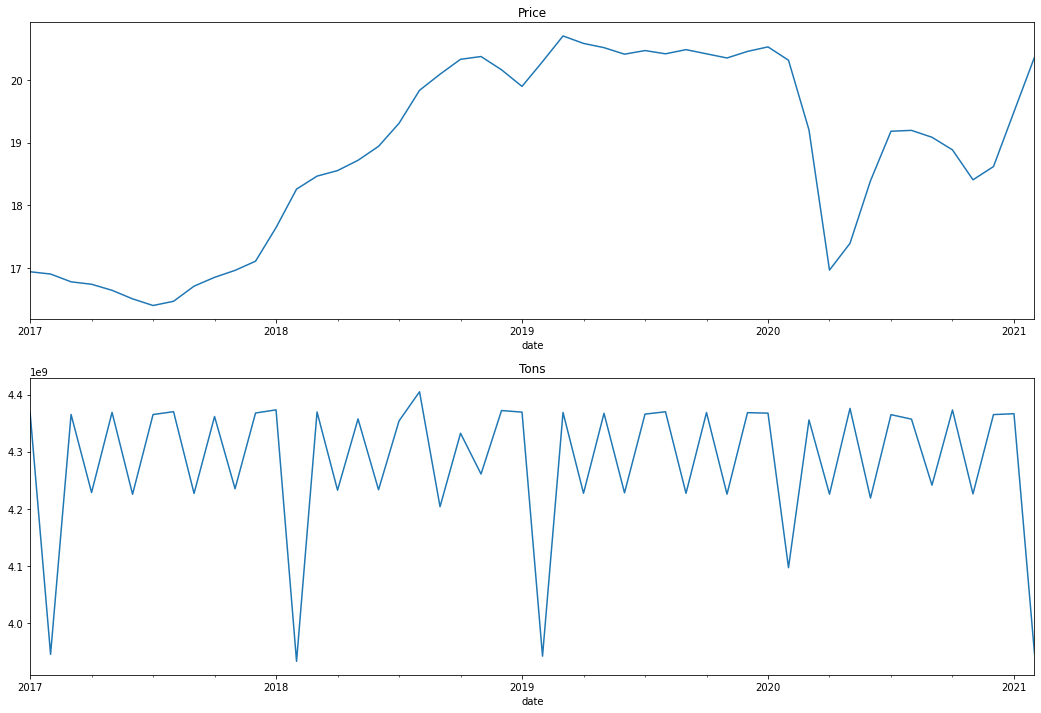

In [ ]:
import matplotlib.pyplot as plt
def plot_monthly_data():
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))

    m = data.groupby(data.date.dt.to_period("M")).agg({'price': 'mean'}).price
    # m.index = m.index.to_period('M')
    axes[0].set_title('Price')
    m.plot(ax=axes[0])

    m = data.groupby(data.date.dt.to_period("M")).agg({'litres': 'sum'}).litres
    # m.index = m.index.to_period('M')
    axes[1].set_title('Tons')
    m.plot(ax=axes[1])

    fig.show()

plot_monthly_data()

### 6.2 Save the data to be used on the next session

In [ ]:
data.to_csv('/content/fuel_dataset.csv', index=False)

# All done with shaping the dataset, see you on the next video where we will fit the machine learning model